In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn
import matplotlib.pyplot as plt

In [4]:
# read data from json file

import json

data = json.load(open('training_data/training_data.json'))

data.keys()

dict_keys(['EVDUQ', 'EtEUA', 'EtFVg', '0BLVw', 'UtGVw', 'EtKUA', 'ENEVQ', 'URAUw', 'kJBUQ', 'EJKVg', '0ZAVg', 'EtAUg', '0REVg', 'UFHVw', 'ERHUw', 'EBHUg', '0RCVw', 'UdAUA', 'kdDVQ', 'EBCXQ', 'UJKXA'])

In [5]:
# for each key in data, get the data by one user

data['EVDUQ'].keys()

dict_keys(['back', 'left', 'right', 'age', 'height', 'weight', 'gender'])

In [6]:
# for each posture, 3 iid observations are collected
np.array(data['EVDUQ']['back']).shape

(3, 24, 32)

In [7]:
# create training set and test set

data_set = []
posture_list = ['back','left','right']

posture_list_id = {'back':0,'left':1,'right':2}

for user in data:
    for posture in posture_list:
        for i in range(3):
            data_set.append({'x':np.array(data[user][posture][i]), 'y':np.array(posture_list_id[posture])})

In [8]:
import numpy as np

data_set_arg = []

range_shift = 6

for n in range(-range_shift,range_shift+1):
    for i in data_set:
        img = i['x']
        min_id = np.argmin(np.mean(img, axis=0))  # Encontre a coluna com a menor temperatura média
        # converta os valores menores que a mediana dessa coluna para o valor da mediana
        img[:, min_id] = np.where(img[:, min_id] < np.median(img[:, min_id]), np.median(img[:, min_id]), img[:, min_id])
        min_id = np.argmin(np.mean(img, axis=0))
        shifted = np.roll(img, n, axis=1)  # Mova a imagem horizontalmente
        if n > 0:
            shifted[:, :n] = img[:, min_id:min_id+1]    # 
            shifted[:, :n] = shifted[:, :n] + np.random.normal(0, 0.25, shifted[:, :n].shape)
        else:
            shifted[:, n:] = img[:, min_id:min_id+1]  
            shifted[:, n:] = shifted[:, n:] + np.random.normal(0,0.25, shifted[:, n:].shape)

        data_set_arg.append({'x': shifted, 'y': i['y']})  # Adicione a imagem modificada ao conjunto de teste

data_set = data_set_arg.copy()

In [9]:
# make k-fold cross validation

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

kf.get_n_splits(data_set)

# rf

from sklearn.ensemble import RandomForestClassifier

acc = []

for train_index, test_index in kf.split(data_set):
    X_train = [data_set[i]['x'].flatten() for i in train_index]
    y_train = [data_set[i]['y'] for i in train_index]
    X_test = [data_set[i]['x'].flatten() for i in test_index]
    y_test = [data_set[i]['y'] for i in test_index]
    clf = RandomForestClassifier(n_estimators=300,max_features=320,max_depth=20,min_samples_leaf=3)
    clf.fit(X_train, y_train)
    acc.append(clf.score(X_test, y_test))

np.mean(acc)

In [ ]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[163,  16,   2],
       [ 11, 152,   1],
       [  4,  12, 130]], dtype=int64)

<Axes: >

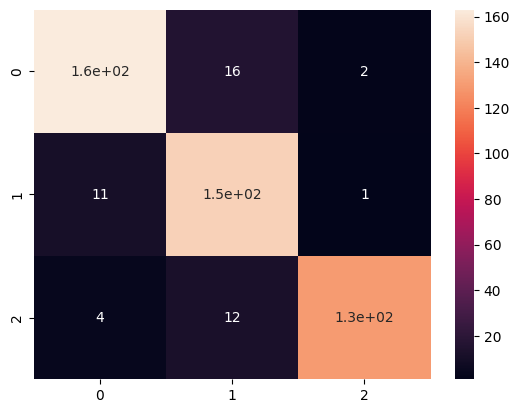

In [ ]:
# plot confusion matrix

import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

acc_xgb = []

kf = KFold(n_splits=5, shuffle=True)

kf.get_n_splits(data_set)

for train_index, test_index in kf.split(data_set):
    X = [data_set[i]['x'].flatten() for i in train_index]
    y = [data_set[i]['y'] for i in train_index]
    X_test = [data_set[i]['x'].flatten() for i in test_index]
    y_test = [data_set[i]['y'] for i in test_index]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    if torch.cuda.is_available():
        model = XGBClassifier(max_depth=7, learning_rate=0.01, n_estimators=3000, objective='multi:softmax', num_class=3, gpu_id=0, verbosity=1)
    else:
        model = XGBClassifier(max_depth=7, learning_rate=0.01, n_estimators=3000, objective='multi:softmax', num_class=3, verbosity=1)
    
    model.fit(np.array(X_train), np.array(y_train), early_stopping_rounds=10, eval_set=[(X_val, y_val)])
    y_pred = model.predict(np.array(X_test))
    acc_xgb.append(np.mean(y_pred == y_test))

    print(np.mean(y_pred == y_test))

print(np.mean(acc_xgb))

c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.09152
[1]	validation_0-mlogloss:1.08447
[2]	validation_0-mlogloss:1.07752
[3]	validation_0-mlogloss:1.07064
[4]	validation_0-mlogloss:1.06392
[5]	validation_0-mlogloss:1.05749
[6]	validation_0-mlogloss:1.05082
[7]	validation_0-mlogloss:1.04452
[8]	validation_0-mlogloss:1.03844
[9]	validation_0-mlogloss:1.03265
[10]	validation_0-mlogloss:1.02657
[11]	validation_0-mlogloss:1.02098
[12]	validation_0-mlogloss:1.01507
[13]	validation_0-mlogloss:1.00941
[14]	validation_0-mlogloss:1.00381
[15]	validation_0-mlogloss:0.99824
[16]	validation_0-mlogloss:0.99239
[17]	validation_0-mlogloss:0.98702
[18]	validation_0-mlogloss:0.98177
[19]	validation_0-mlogloss:0.97668
[20]	validation_0-mlogloss:0.97154
[21]	validation_0-mlogloss:0.96659
[22]	validation_0-mlogloss:0.96130
[23]	validation_0-mlogloss:0.95631
[24]	validation_0-mlogloss:0.95140
[25]	validation_0-mlogloss:0.94616
[26]	validation_0-mlogloss:0.94133
[27]	validation_0-mlogloss:0.93631
[28]	validation_0-mlogloss:0.9

In [ ]:
# print accuracy

np.mean(acc_xgb)

0.8937641779676453

In [ ]:
# SVM

from sklearn.svm import SVC

acc_svm = []

for train_index, test_index in kf.split(data_set):
    X_train = [data_set[i]['x'].flatten() for i in train_index]
    y_train = [data_set[i]['y'] for i in train_index]
    X_test = [data_set[i]['x'].flatten() for i in test_index]
    y_test = [data_set[i]['y'] for i in test_index]
    clf = SVC(gamma='auto')
    clf.fit(X_train, y_train)
    acc_svm.append(clf.score(X_test, y_test))

np.mean(acc_svm)

0.9442410544268375

In [ ]:
# SVM

from sklearn.svm import SVC

acc_svm = []

for train_index, test_index in kf.split(data_set):
    X_train = [data_set[i]['x'].flatten() for i in train_index]
    y_train = [data_set[i]['y'] for i in train_index]
    X_test = [data_set[i]['x'].flatten() for i in test_index]
    y_test = [data_set[i]['y'] for i in test_index]
    clf = SVC(kernel='rbf',gamma='auto',C=2,degree=5,coef0=0.0,shrinking=True,probability=True,tol=0.001,cache_size=200,class_weight=None,verbose=False,max_iter=-1,decision_function_shape='ovr',break_ties=False,random_state=None)
    clf.fit(X_train, y_train)
    acc_svm.append(clf.score(X_test, y_test))

np.mean(acc_svm)

0.943028165515871